In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = [16, 8]
cmap = plt.cm.get_cmap('brg', 3)

Data collected by Heide-Jørgensen, Mads Peter et al. (2021)
Available at https://datadryad.org/stash/dataset/doi:10.5061%2Fdryad.zcrjdfn81

In [2]:
data_all = pd.read_csv('data/doi_10.5061_dryad.zcrjdfn81__v2/Acou_data_13-18.txt', sep='\t')
data_all['DateTime'] = pd.to_datetime(data_all['DateTime'])

In [6]:
data_all[['ID', 'DateTime']].groupby('ID').apply(lambda x: x.max() - x.min())

,DateTime
ID,
Acou/MM1,1 days 07:27:01
Acou/MM10,2 days 15:28:27
Acou/MM11,8 days 02:50:24
Acou/MM12,6 days 05:39:10
Acou/MM13,8 days 01:22:29
Acou/MM14,4 days 15:11:45
Acou/MM15,4 days 06:47:30
Acou/MM16,4 days 06:15:54
Acou/MM2,0 days 01:00:54


In [170]:
data = data_all[data_all['ID'] == 'Acou/MM3']
data

,ID,DateTime,Depth,Buzz,temperatureCorrected
113222,Acou/MM3,2014-08-12 00:58:00,-127.348400,0.0,1.474265
113223,Acou/MM3,2014-08-12 00:58:01,-129.189400,0.0,1.375837
113224,Acou/MM3,2014-08-12 00:58:02,-131.054500,0.0,1.278400
113225,Acou/MM3,2014-08-12 00:58:03,-132.877400,0.0,1.189292
113226,Acou/MM3,2014-08-12 00:58:04,-134.772500,0.0,1.093726
...,...,...,...,...,...
452933,Acou/MM3,2014-08-15 22:18:56,0.684500,0.0,-0.282401
452934,Acou/MM3,2014-08-15 22:18:57,0.684500,0.0,-0.270688
452935,Acou/MM3,2014-08-15 22:18:58,0.540108,0.0,-0.254695
452936,Acou/MM3,2014-08-15 22:18:59,0.106935,0.0,-0.247695


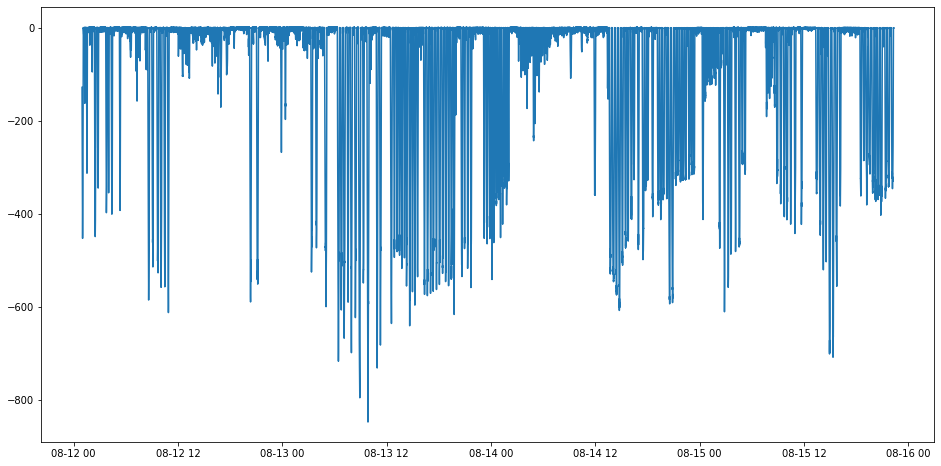

In [171]:
plt.plot(data['DateTime'], data['Depth'])

In [172]:
data_diff = data[['DateTime']][:-1]
data_diff['Depth'] = np.diff(data['Depth'])

How to identify dives:
- A dive starts and stops approximately a the same hight close to data['Depth'].max()
- A dive is not part of a bigger dive
- Idea definition: a dive is a max1-min1-max2 triple with abs(max1 - max2) < min(max1-min1, max2-min2), i.e. the depth of a dive is bigger than the difference between the starting and end point
- Also, everything shallower than 15 cm is probably noise

In [264]:
filter_max = (data['Depth'][:-2].values < data['Depth'][1:-1].values) \
    & (data['Depth'][1:-1].values >= data['Depth'][2:].values)
filter_max = np.insert(filter_max, 0, False)  # padding
filter_max = np.append(filter_max, False)

# make sure we start and stop on a max near the surface
filter_max[:np.where(filter_max & (data['Depth'] > data['Depth'].max() - 10))[0].min() - 1] = False
filter_max[np.where(filter_max & (data['Depth'] > data['Depth'].max() - 10))[0].max() + 1:] = False

filter_min = (data['Depth'][:-2].values >= data['Depth'][1:-1].values) \
    & (data['Depth'][1:-1].values < data['Depth'][2:].values)
filter_min = np.insert(filter_min, 0, False)  # padding
filter_min = np.append(filter_min, False)

filter_min[:np.where(filter_max)[0].min()] = False  # make sure we start and end with a max
filter_min[np.where(filter_max)[0].max():] = False

In [252]:
# Nr triples:
sum(filter_min)

25433

In [253]:
# sanity check: are there 2 min without a max in between or vice versa?
# if everything went right this should yield [0, 1] (because we start with a max)
np.unique((1*filter_max - 1*filter_min).cumsum())

array([0, 1])

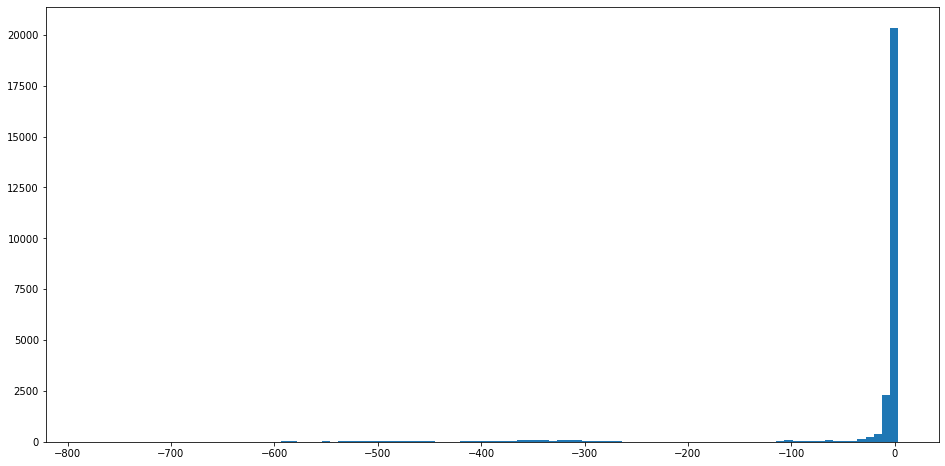

In [254]:
plt.hist(data['Depth'][filter_max], 100)
pass

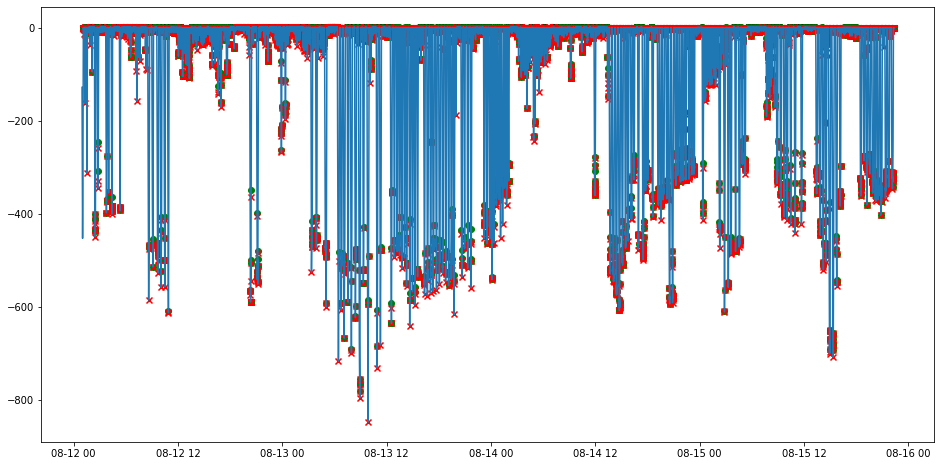

In [255]:
plt.plot(data['DateTime'], data['Depth'])
plt.scatter(data['DateTime'][filter_max], data['Depth'][filter_max], marker='o', c='green')
plt.scatter(data['DateTime'][filter_min], data['Depth'][filter_min], marker='x', c='red')

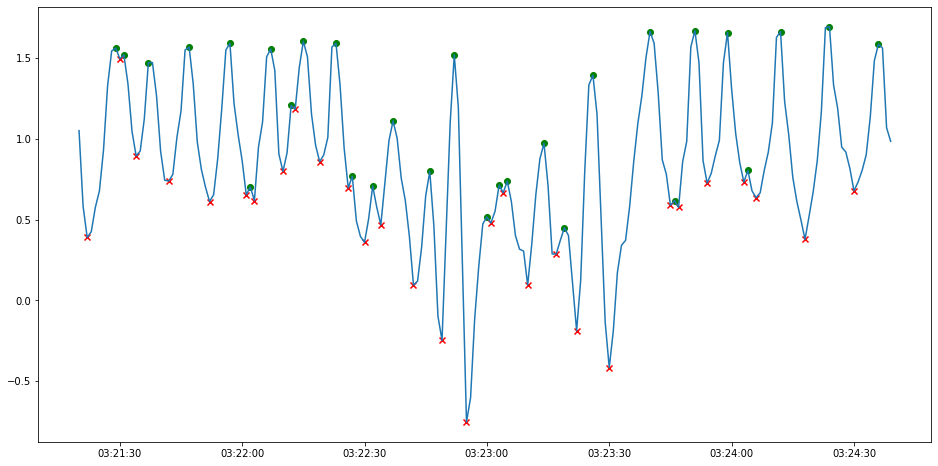

In [256]:
start = 8600
stop = start + 200
plt.plot(data['DateTime'][start:stop], data['Depth'][start:stop])
plt.scatter(
    data['DateTime'][start:stop][filter_max[start:stop]], 
    data['Depth'][start:stop][filter_max[start:stop]],
    marker='o',
    c='green'
)
plt.scatter(
    data['DateTime'][start:stop][filter_min[start:stop]], 
    data['Depth'][start:stop][filter_min[start:stop]],
    marker='x',
    c='red'
)

In [265]:
while True:
    triple_depth = np.minimum(
        data['Depth'][filter_max][:-1].values - data['Depth'][filter_min].values,
        data['Depth'][filter_max][1:].values - data['Depth'][filter_min].values
    )
    triple_diff = abs(data['Depth'][filter_max][:-1].values - data['Depth'][filter_max][1:].values)
    smaller_max = np.where(
        data['Depth'][filter_max][:-1].values < data['Depth'][filter_max][1:].values, 
        np.where(filter_max)[0][:-1], np.where(filter_max)[0][1:]
    )

    triple_bad = (triple_depth < triple_diff) | (triple_depth < 0.15)
    print('Nr bad triples: ', sum(triple_bad))
    if not sum(triple_bad):
        break

    filter_max[smaller_max[triple_bad]] = False  # remove smaller max of non-dives

    # fuse mins where there are multiple in a row:
    triple_groups = np.split(np.arange(data.shape[0]), np.where(filter_max)[0])
    smallest_mins = np.array([tg[data['Depth'].values[tg].argmin()] for tg in triple_groups])
    filter_min[:] = False
    filter_min[smallest_mins] = True

    filter_min[:np.where(filter_max)[0].min()] = False  # make sure we start and end with a max
    filter_min[np.where(filter_max)[0].max():] = False

Nr bad triples:  16858
Nr bad triples:  2377
Nr bad triples:  496
Nr bad triples:  151
Nr bad triples:  65
Nr bad triples:  33
Nr bad triples:  20
Nr bad triples:  9
Nr bad triples:  3
Nr bad triples:  2
Nr bad triples:  2
Nr bad triples:  2
Nr bad triples:  2
Nr bad triples:  2
Nr bad triples:  0


In [266]:
# Nr triples:
sum(filter_min)

10655

In [267]:
# sanity check: are there 2 min without a max in between or vice versa?
# if everything went right this should yield [0, 1] (because we start with a max)
np.unique((1*filter_max - 1*filter_min).cumsum())

array([0, 1])

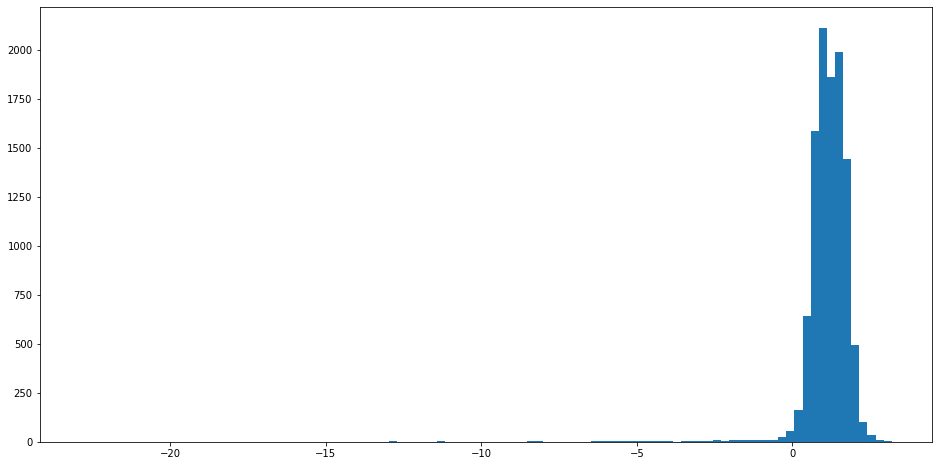

In [268]:
plt.hist(data['Depth'][filter_max], 100)
pass

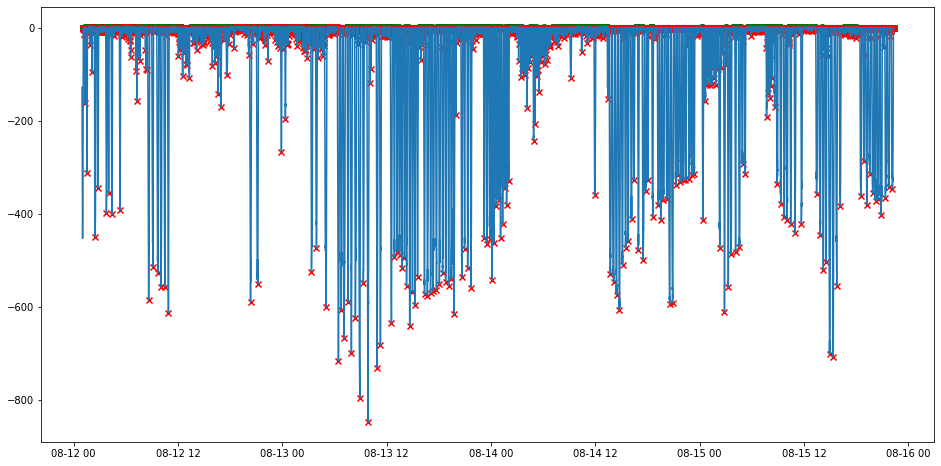

In [269]:
plt.plot(data['DateTime'], data['Depth'])
plt.scatter(data['DateTime'][filter_max], data['Depth'][filter_max], marker='o', c='green')
plt.scatter(data['DateTime'][filter_min], data['Depth'][filter_min], marker='x', c='red')

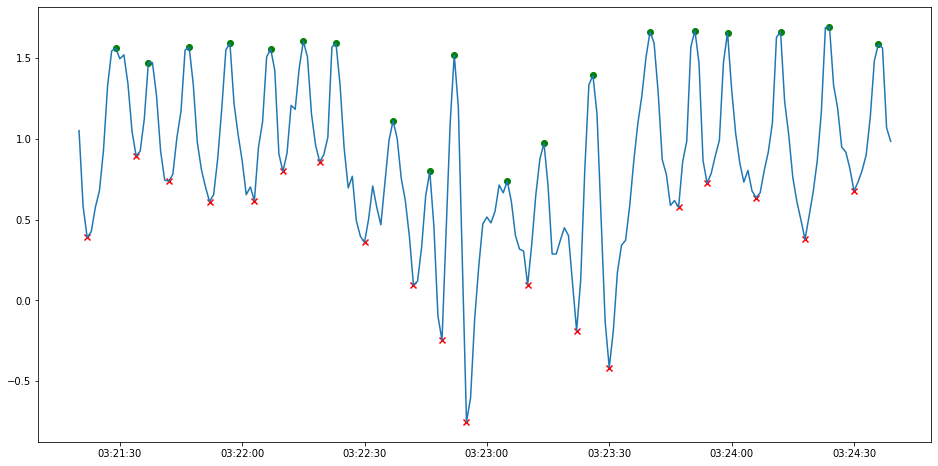

In [270]:
start = 8600
stop = start + 200
plt.plot(data['DateTime'][start:stop], data['Depth'][start:stop])
plt.scatter(
    data['DateTime'][start:stop][filter_max[start:stop]], 
    data['Depth'][start:stop][filter_max[start:stop]],
    marker='o',
    c='green'
)
plt.scatter(
    data['DateTime'][start:stop][filter_min[start:stop]], 
    data['Depth'][start:stop][filter_min[start:stop]],
    marker='x',
    c='red'
)

Text(0.5, 0, 'Depth of the dive: min(max1-min1, max2-min2)')

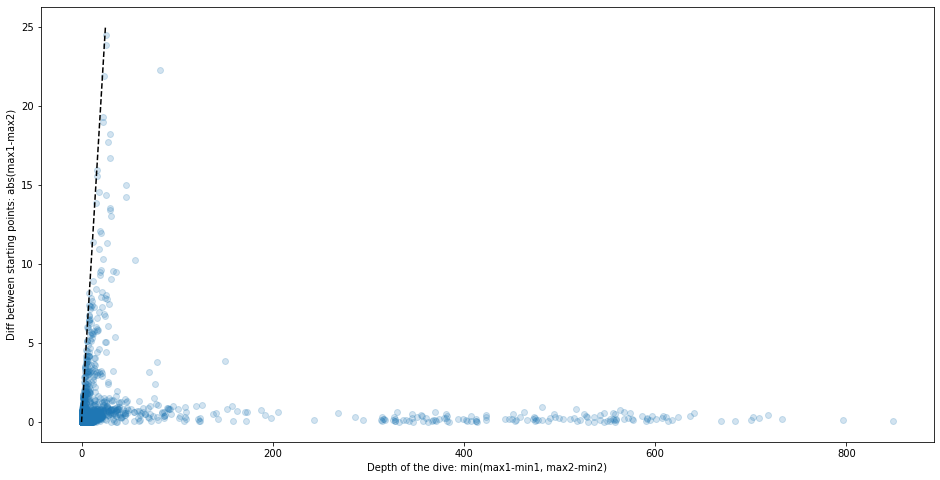

In [274]:
plt.scatter(
    np.minimum(
        data['Depth'][filter_max][:-1].values - data['Depth'][filter_min].values,
        data['Depth'][filter_max][1:].values - data['Depth'][filter_min].values
    ),
    abs(np.diff(data['Depth'][filter_max])), 
    alpha=0.2
)
plt.plot([0, 25], [0, 25], '--', c='black')
plt.ylabel('Diff between starting points: abs(max1-max2)')
plt.xlabel('Depth of the dive: min(max1-min1, max2-min2)')

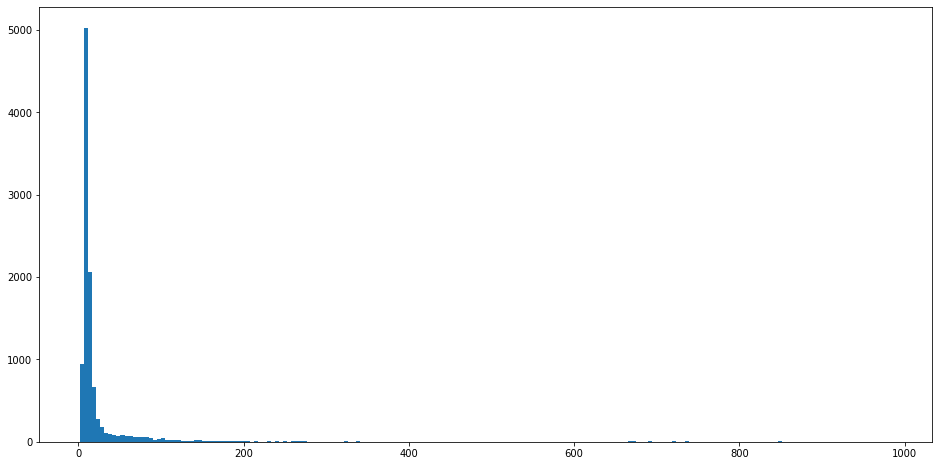

In [275]:
# distribution of dive length in seconds
plt.hist(np.diff(np.where(filter_max)[0]), 200)
pass

In [276]:
# 90% of the curves are shorter than 1 min
sum(np.diff(np.where(filter_max)[0]) <= 60) / sum(filter_min)

0.9067104645706241

In [277]:
# 0%, 5%, 10%, ... , 95%, 100% quantiles
np.quantile(np.diff(np.where(filter_max)[0]), np.arange(21)/20)

array([  2.,   6.,   7.,   7.,   8.,   8.,   9.,   9.,  10.,  10.,  11.,
        11.,  12.,  13.,  15.,  16.,  20.,  28.,  56., 104., 984.])

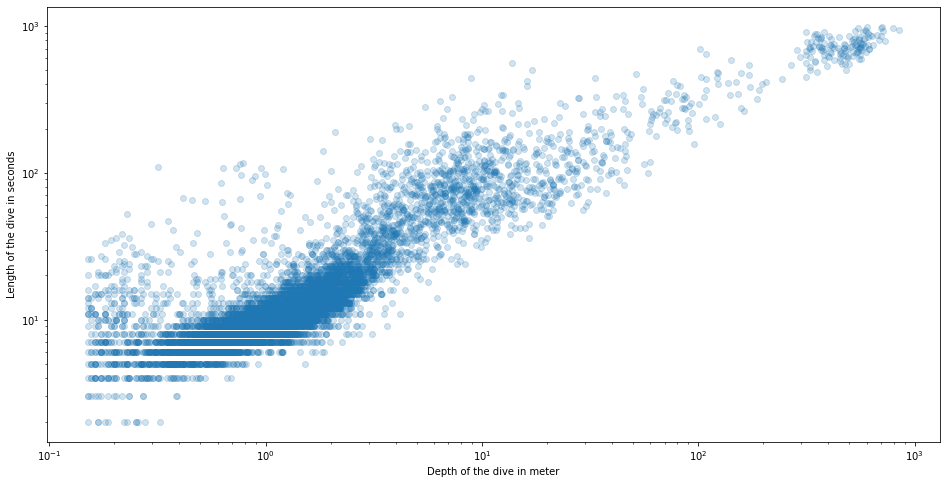

In [278]:
plt.scatter(
    np.minimum(
        data['Depth'][filter_max][:-1].values - data['Depth'][filter_min].values,
        data['Depth'][filter_max][1:].values - data['Depth'][filter_min].values
    ),
    np.diff(np.where(filter_max)[0]), 
    alpha=0.2
)
plt.ylabel('Length of the dive in seconds')
plt.xlabel('Depth of the dive in meter')
#plt.xlim(0, 40)
plt.xscale('log')
plt.yscale('log')

# unfortunately, dives and minimoovement near the surface are not as clearly distinguished as I hoped..

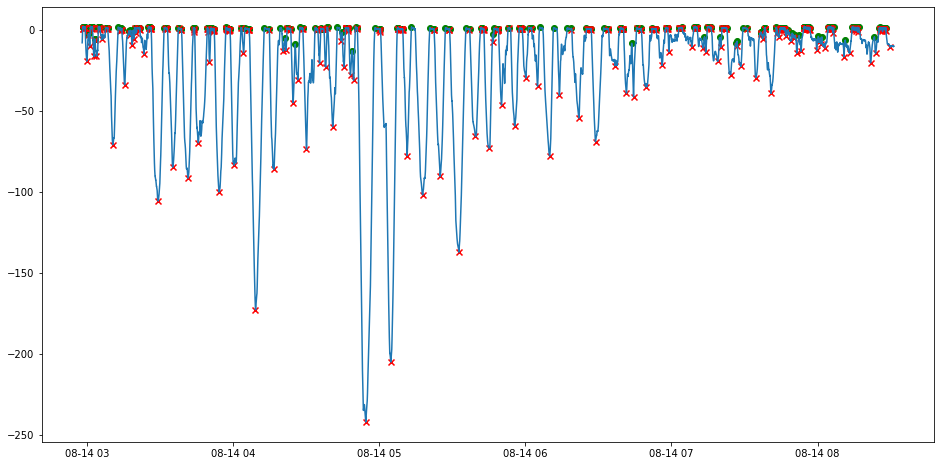

In [279]:
# example for an interval with a range of different dives depths
start = 180000
stop = start + 20000
plt.plot(data['DateTime'][start:stop], data['Depth'][start:stop])
plt.scatter(
    data['DateTime'][start:stop][filter_max[start:stop]], 
    data['Depth'][start:stop][filter_max[start:stop]],
    marker='o',
    c='green'
)
plt.scatter(
    data['DateTime'][start:stop][filter_min[start:stop]], 
    data['Depth'][start:stop][filter_min[start:stop]],
    marker='x',
    c='red'
)

(0.5, 1.8)

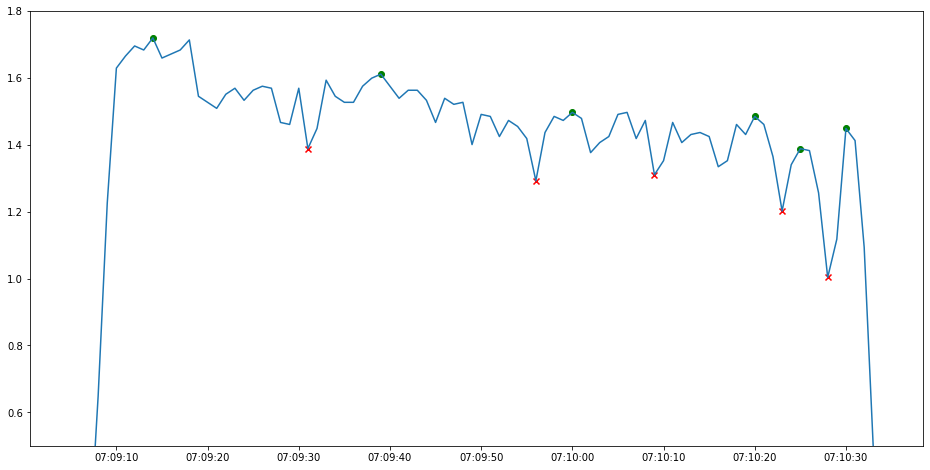

In [287]:
# noisy 20s, not sure what's the best way to divide these
start = 195065
stop = start + 90
plt.plot(data['DateTime'][start:stop], data['Depth'][start:stop])
plt.scatter(
    data['DateTime'][start:stop][filter_max[start:stop]], 
    data['Depth'][start:stop][filter_max[start:stop]],
    marker='o',
    c='green'
)
plt.scatter(
    data['DateTime'][start:stop][filter_min[start:stop]], 
    data['Depth'][start:stop][filter_min[start:stop]],
    marker='x',
    c='red'
)
plt.ylim(0.5, 1.8)